### Note: this notebook contains code developed by Z. Ivezic, M. Juric, A. Connolly, B. Sippocz, Jake VanderPlas, G. Richards and others.

# Introduction to ipython (jupyter) notebooks 


## Introduction

In this notebook, we'll cover some basic statistics and we'll fit a line to a set of data points with Gaussian uncertainties in one dimension.   

This worksheet is written in Python and it lives in an IPython notebook. In this context, you'll be asked to write a few lines of code to implement the sampler and the models but much of the boilerplate code is already in place. Therefore, even if you're not familiar with Python, you should be able to get something out of the notebook. I don't expect that everyone will finish the full notebook but that's fine because it has been designed to get more difficult as we progress.

## How to use the notebook

*If you're familiar with IPython notebooks, you can probably skip this section without missing anything.*

IPython notebooks work by running a fully functional Python sever behind the scenes and if you're reading this then you probably already figured out how to get that running. Then, inside the notebook, the content is divided into cells containing code or text.

You'll be asked to edit a few of the cells below to add your own code. To do this, click on the cell to start editing and then type as you normally would. To execute the code contained in the cell, press `Shift-Enter`. Even for existing cells that you don't need to edit, you should select them and type `Shift-Enter` when you get there because the cells below generally depend on the previous cells being executed first.

To get started, edit the cell below to assign your name (or whatever you want) to the variable `name` and then press `Shift-Enter` to execute the cell.

In [6]:
import os
name = os.getlogin()
print("Hello {0}!".format(name))

Hello ivezic!


If this works, the output should greet you without throwing any errors. If so, that's pretty much all we need so let's get started!

## Dataset 1: Fitting a line to data

We will load the data first and then obtain the best-fit least squares solution.

### Load the data

I've generated a simulated dataset generated from a linear model with no uncertainties in the $x$ dimension and known Gaussian uncertainties in the $y$ dimension. These data are saved in the CSV file `linear.csv` included with this notebook.

First we'll need `numpy` and `matplotlib` so let's import them:

In [9]:
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100  # This makes all the plots a little bigger.
import numpy as np
import matplotlib.pyplot as plt

Now we'll load the datapoints and plot them. When you execute the following cell, you should see a plot of the data. If not, make sure that you run the import cell from above first.

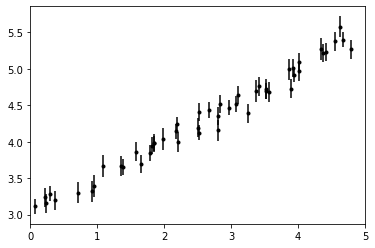

In [11]:
# Load the data from the CSV file.
x, y, yerr = np.loadtxt("linear.csv", delimiter=",", unpack=True)

# Plot the data with error bars.
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlim(0, 5);

For this problem the maximum likelihood and full posterior probability distribution (under infinitely broad priors) for the slope and intercept of the line are known analytically. The analytic result for the posterior probability distribution is a 2-d Gaussian with mean

$$\mathbf{w} = \left(\begin{array}{c}
    m \\ b
\end{array}\right) = (\mathbf{A}^\mathrm{T}\,C^{-1}\mathbf{A})^{-1} \, \mathbf{A}^\mathrm{T}\,C^{-1}\,\mathbf{y}$$

and covariance matrix

$$\mathbf{V} = (\mathbf{A}^\mathrm{T}\,C^{-1}\mathbf{A})^{-1}$$

where

$$\mathbf{y} = \left(\begin{array}{c}
y_1 \\ y_2 \\ \vdots \\ y_N
\end{array}\right) \quad , \quad \mathbf{A} = \left(\begin{array}{cc}
x_1 & 1 \\ x_2 & 1 \\ \vdots & \vdots \\ x_N & 1
\end{array}\right) \quad ,\, \mathrm{and} \quad
\mathbf{C} = \left(\begin{array}{cccc}
\sigma_1^2 & 0 & \cdots & 0 \\
0 & \sigma_2^2 & \cdots & 0 \\
&&\ddots& \\
0 & 0 & \cdots & \sigma_N^2
\end{array}\right)$$

There are various functions in Python for computing this but I prefer to do it myself (it only takes a few lines of code!) and here it is:

In [12]:
A = np.vander(x, 2)  # Take a look at the documentation to see what this function does!
                     # https://numpy.org/doc/stable/reference/generated/numpy.vander.html
ATA = np.dot(A.T, A / yerr[:, None]**2)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2))
V = np.linalg.inv(ATA)

Let's take a look and see what this prediction looks like. To do this, we'll sample 99 slopes and intercepts from this 2-D Gaussian and overplot them on the data.

Text(0, 0.5, 'y')

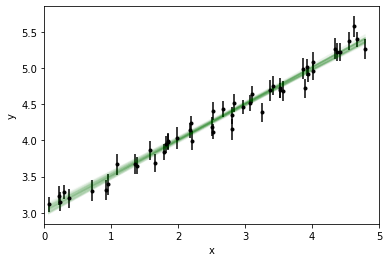

In [21]:
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
for m, b in np.random.multivariate_normal(w, V, size=99):
    plt.plot(x, m*x + b, "g", alpha=0.02)
plt.xlim(0, 5);
plt.xlabel('x')
plt.ylabel('y')

Text(0, 0.5, 'b')

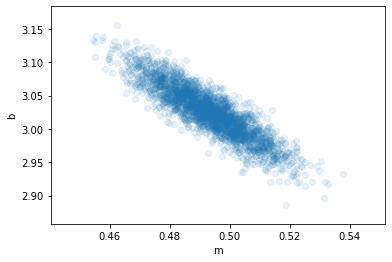

In [20]:
# let's visualize the covariance between m and b
a = np.random.multivariate_normal(w, V, size=2400)
plt.scatter(a[:,0], a[:,1], alpha=0.1)
plt.xlabel('m')
plt.ylabel('b') 

### The probabilistic model

In order to perform posterior inference on a model and dataset, we need a function that computes the value of the posterior probability given a proposed setting of the parameters of the model. For reasons that will become clear below, we actually only need to return a value that is *proportional* to the probability.

As discussed in a previous tutorial, the posterior probability for parameters $\mathbf{w} = (m,\,b)$ conditioned on a dataset $\mathbf{y}$ is given by

$$p(\mathbf{w} \,|\, \mathbf{y}) = \frac{p(\mathbf{y} \,|\, \mathbf{w}) \, p(\mathbf{w})}{p(\mathbf{y})}$$

where $p(\mathbf{y} \,|\, \mathbf{w})$ is the *likelihood* and $p(\mathbf{w})$ is the *prior*. For this example, we're modeling the likelihood by assuming that the datapoints are independent with known Gaussian uncertainties $\sigma_n$. This specifies a likelihood function:

$$p(\mathbf{y} \,|\, \mathbf{w}) = \prod_{n=1}^N \frac{1}{\sqrt{2\,\pi\,\sigma_n^2}} \,
\exp \left(-\frac{[y_n - f_\mathbf{w}(x_n)]^2}{2\,\sigma_n^2}\right)$$

where $f_\mathbf{w}(x) = m\,x + b$ is the linear model.

For numerical reasons, we will acutally want to compute the logarithm of the likelihood. In this case, this becomes:

$$\ln p(\mathbf{y} \,|\, \mathbf{w}) = -\frac{1}{2}\sum_{n=1}^N \frac{[y_n - f_\mathbf{w}(x_n)]^2}{\sigma_n^2} + \mathrm{constant} \quad.$$

In the following cell, replace the contents of the `lnlike_linear` function to implement this model. The function takes two values (`m` and `b`) as input and it should return the log likelihood (a single number) up to a constant. In this function, you can just use the globaly defined dataset `x`, `y` and `yerr`. For performance, I recommend using vectorized numpy operations (the key function will be `np.sum`).

In [6]:
def lnlike_linear((m, b)):
    # CODE HERE
    f = m*x + b
    return -0.5 * np.sum(((y-f) / yerr) ** 2)

SyntaxError: invalid syntax (<ipython-input-6-a5bf12d9fbab>, line 1)

After you're satisfied with your implementation, run the following cell. In this cell, we're checking to see if your code is right. If it is, you'll see a smiling face (☺︎) but if not, you'll get an error message.

In [ ]:
p_1, p_2 = (0.0, 0.0), (0.01, 0.01)
ll_1, ll_2 = lnlike_linear(p_1), lnlike_linear(p_2)
if not np.allclose(ll_2 - ll_1, 535.8707738280209):
    raise ValueError("It looks like your implementation is wrong!")
print("☺︎")

If you don't get the ☺︎, go back and try to debug your model. Iterate until your result is correct.

Once you get that, we'll use this to implement the full model (*Remember: we haven't added in the prior yet*). For the purposes of this demonstration, we'll assume infinitely broad uniform priors on both $m$ and $b$. This isn't generally a good idea... instead, you should always apply some sort of prior constraint that

**FINISH THIS**

In [ ]:
def lnprior_linear((m, b)):
    if not (-10 < m < 10):
        return -np.inf
    if not (-10 < b < 10):
        return -np.inf
    return 0.0

In [ ]:
def lnpost_linear(theta):
    return lnprior_linear(theta) + lnlike_linear(theta)